## Identifying Duplicate Questions

Over 100 million people visit Quora every month, so it's no surprise that many people ask similar (or the same) questions. Various questions with the same intent can cause people to spend extra time searching for the best answer to their question, and results in members answering multiple versions of the same question. Quora uses random forest to identify duplicated questions to provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
Follow the steps outlined below to build the appropriate classifier model. 


Steps:
- Download data
- Exploration
- Cleaning
- Feature Engineering
- Modeling

By the end of this project you should have **a presentation that describes the model you built** and its **performance**. 


In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("train.csv")

#### Note
There is no designated test.csv file. The train.csv file is the entire dataset. Part of the data in the train.csv file should be set aside to act as the final testing data.

### Exploration

In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [19]:
# drop meaningless columns: id, qid1, qid2
df = df.drop(['id','qid1','qid2'],axis=1)

In [20]:
df.shape

(298526, 3)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298526 entries, 0 to 298525
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   question1     298526 non-null  object
 1   question2     298526 non-null  object
 2   is_duplicate  298526 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 6.8+ MB


In [22]:
df.isnull().sum()

question1       0
question2       0
is_duplicate    0
dtype: int64

In [23]:
# Drop any NAN entries
df = df.dropna()

In [10]:
# mild class imbalance; 37% of questions are duplicate.  Train and test are similarly imbalanced.
print('frequency of duplicates in df is {:.2f}%'.format(df['is_duplicate'].mean()*100))

frequency of duplicates in df is 50.00%


In [13]:
# Resolve minor target class imbalance; can also use SMOTE

# Select randomly a subset of non-duplicate questions to match the number of duplicate questions
duplicates = df[df['is_duplicate'] == 1]
non_duplicates = df[df['is_duplicate'] == 0]
duplicates_count = len(duplicates)
non_duplicates_sampled = non_duplicates.sample(duplicates_count) # Select a subset of non-duplicate questions

# Combine the sampled non-duplicate questions with the original duplicate questions
df = pd.concat([duplicates, non_duplicates_sampled], axis=0) 

# Shuffle the dataset to ensure that the duplicate and non-duplicate questions are mixed
df = df.sample(frac=1).reset_index(drop=True)
print('new frequency of duplicates in df is {:.2f}%'.format(df['is_duplicate'].mean()*100))
print(duplicates_count*2, 'total observations')

new frequency of duplicates in df is 50.00%
298526 total observations


### Cleaning

- Tokenization
- Stopwords cleaning
- Removing punctuation
- Normalizing
- Stemming

In [14]:
# TODO: Spelling, 

In [29]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import string

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/connorl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/connorl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [10]:
### Attempt 1: too computationally heavy

# def clean_text(df):
#     # convert to lowercase
#     text = df.lower()
    
#     # tokenize the text into individual words
#     tokens = word_tokenize(text)

#     # remove stopwords
#     stop_words = set(stopwords.words('english'))
#     filtered_tokens = [word for word in tokens if word not in stop_words]

#     # remove punctuation
#     translator = str.maketrans('', '', string.punctuation)
#     no_punct_tokens = [word.translate(translator) for word in filtered_tokens]

#     # perform stemming
#     stemmer = PorterStemmer()
#     stemmed_tokens = [stemmer.stem(word) for word in no_punct_tokens]

#     # return cleaned text as a string
#     return ' '.join(stemmed_tokens)

# # apply the function to the 'text' column of the dataframe
# df['cleaned_q1'] = df['question1'].apply(clean_text)
# df['cleaned_q2'] = df['question2'].apply(clean_text)
# df = df.drop(['question1','question2'],axis=1)

In [32]:
def text_preprocessing(text):
    # tokenize the text
    tokens = nltk.word_tokenize(text)

    # preprocess each token by iterating through each one 
    text = []
    for token in tokens:
        # convert to lowercase
        token = token.lower()
        # remove punctuation and digits
        token = re.sub(r'[^\w\s]', '', token)
        # remove non-alphabetic characters
        token = re.sub(r'[^a-zA-Z\s]', '', token)
        # stem the word
        token = stemmer.stem(token)
        # add the preprocessed tokens into the text list
        if token not in stop_words:
            text.append(token) 

    # join the words back into a string
    clean_text = ' '.join(text)

    return clean_text

In [33]:
# Apply preprocessing to Q1
df['cleaned_q1'] = df['question1'].apply(text_preprocessing)
df = df.drop(['question1'],axis=1)

In [35]:
# Apply preprocessing to Q2
df['cleaned_q2'] = df['question2'].apply(text_preprocessing)
df = df.drop(['question2'],axis=1)

,question1,is_duplicate,cleaned_q1,cleaned_q2
0,What experience would you like to have in zero...,0,experi would like zero graviti,like experi zero graviti
1,How many countries are there in the world? Tha...,1,mani countri world thank,mani countri
2,What mammals are at the top of the food chain ...,0,mammal top food chain us,mammal top food chain australia
3,What are the side effects of Mobiflex tablets?,0,side effect mobiflex tablet,side effect tablet alprax mg
4,What was the first operating system made? What...,1,wa first oper system made wa histori,first oper system
...,...,...,...,...
298521,How do they make smokes?,0,make smoke,make smoke ring
298522,What do you see in a typewriter before you buy...,0,see typewrit befor buy,know want buy typewrit
298523,What are the similarities and differences betw...,0,similar differ aztec inca empir,inca achiev influenc aztec
298524,Is Popcorn Time legal in Canada?,0,popcorn time legal canada,ha anyon encount legal troubl watch movi popul...


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298526 entries, 0 to 298525
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   is_duplicate  298526 non-null  int64 
 1   cleaned_q1    298526 non-null  object
 2   cleaned_q2    298526 non-null  object
dtypes: int64(1), object(2)
memory usage: 6.8+ MB


In [40]:
df.tail()

,is_duplicate,cleaned_q1,cleaned_q2
298521,0,make smoke,make smoke ring
298522,0,see typewrit befor buy,know want buy typewrit
298523,0,similar differ aztec inca empir,inca achiev influenc aztec
298524,0,popcorn time legal canada,ha anyon encount legal troubl watch movi popul...
298525,1,way get updat job open experienc profession,best job site get updat open experienc profess...


### Feature Engineering

- tf-idf
- word2vec
- word count
- number of the same words in both questions
- ....

In [42]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models import Word2Vec
from gensim.utils import tokenize

#### TF-IDF

In [43]:
vectorizer = TfidfVectorizer(tokenizer=tokenize, stop_words='english', analyzer='word')

# create a TfidfVectorizer object with some parameters
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features=1000)

# fit and transform the preprocessed text for both questions
tfidf_question1 = tfidf_vectorizer.fit_transform(df['cleaned_q1'])
tfidf_question2 = tfidf_vectorizer.fit_transform(df['cleaned_q2'])

In [44]:
# create pandas DataFrame from tfidf_vectorizer_data
tfidf_q1_df = pd.DataFrame(tfidf_question1.toarray())
tfidf_q2_df = pd.DataFrame(tfidf_question2.toarray())

In [45]:
# Attempt 1: Too computationally heavy
# Transform
# df['q1_tfidf'] = list(vectorizer.transform(df['cleaned_q1']).toarray())
# df['q2_tfidf'] = list(vectorizer.transform(df['cleaned_q2']).toarray())

#### Word2Vec

In [46]:
# combine all text and split into words
all_text = df['cleaned_q1'] + df['cleaned_q2']
all_words = [sentence.split() for sentence in all_text]

In [47]:
# Train a Word2Vec model on all words
w2v_model = Word2Vec(all_words, min_count=2)

In [48]:
# Create dictionary with frequency of each unique word
word_freq = {}
for words in all_words:
    for word in words:
        if word not in word_freq:
            word_freq[word] = 1
        else:
            word_freq[word] += 1

In [49]:
# Count number of unique words with count >=2
def count_unique_words(row):
    question = row['cleaned_q1'] + row['cleaned_q2']
    words = question.split()
    count = 0
    for word in set(words):
        if word_freq[word] > 2:
            count += 1
    return count

In [50]:
# create column in dataframe
df['unique_word_count'] = df.apply(count_unique_words, axis=1)

In [52]:
df.head()

,is_duplicate,cleaned_q1,cleaned_q2,unique_word_count
0,0,experi would like zero graviti,like experi zero graviti,5
1,1,mani countri world thank,mani countri,4
2,0,mammal top food chain us,mammal top food chain australia,6
3,0,side effect mobiflex tablet,side effect tablet alprax mg,4
4,1,wa first oper system made wa histori,first oper system,6


#### Word Count

In [53]:
from sklearn.feature_extraction.text import CountVectorizer

In [54]:
# Instatiate Count Vectorizer
count_vectorizer = CountVectorizer()

In [55]:
# fit and transform
count_q1 = count_vectorizer.fit_transform(df['cleaned_q1'])
count_q2 = count_vectorizer.fit_transform(df['cleaned_q2'])

In [56]:
print('total words:', len(count_vectorizer.vocabulary_))

total words: 40781


In [57]:
# word count per row per token
df['q1_word_count'] = df['cleaned_q1'].str.split().apply(len)
df['q2_word_count'] = df['cleaned_q2'].str.split().apply(len)

In [58]:
df.head(2)

,is_duplicate,cleaned_q1,cleaned_q2,unique_word_count,q1_word_count,q2_word_count
0,0,experi would like zero graviti,like experi zero graviti,5,5,4
1,1,mani countri world thank,mani countri,4,4,2


#### Word similarity

In [59]:
from sklearn.metrics.pairwise import cosine_similarity

In [61]:
#Create corpus for processing
corpus = pd.concat([df['cleaned_q1'], df['cleaned_q2']])

In [62]:
vectorizer = TfidfVectorizer()
vectorizer.fit(corpus)

TfidfVectorizer()

In [64]:
vectors_q1 = vectorizer.transform(df['cleaned_q1'])
vectors_q2 = vectorizer.transform(df['cleaned_q2'])

In [65]:
# Cosine similarities (orientation similarity, regardless of magnitude)

cosine_sim_list = []

for i in range(len(df)):
       
        cosine_sim_list.append(cosine_similarity(vectors_q1[i], vectors_q2[i]))

In [68]:
# Calculate similarity
s = 0
cosine_sim = []

while s < df.shape[0]:
    cosine_sim.append(cosine_sim_list[s][0][0])
    s += 1

In [70]:
# Add feature
df['cosine_similarity'] = cosine_sim

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298526 entries, 0 to 298525
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   is_duplicate       298526 non-null  int64  
 1   cleaned_q1         298526 non-null  object 
 2   cleaned_q2         298526 non-null  object 
 3   unique_word_count  298526 non-null  int64  
 4   q1_word_count      298526 non-null  int64  
 5   q2_word_count      298526 non-null  int64  
 6   cosine_similarity  298526 non-null  float64
dtypes: float64(1), int64(4), object(2)
memory usage: 15.9+ MB


### Split into train and test

In [74]:
from sklearn.model_selection import train_test_split

X = df.drop(['is_duplicate'],axis=1)
y = df['is_duplicate']

In [75]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298526 entries, 0 to 298525
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   cleaned_q1         298526 non-null  object 
 1   cleaned_q2         298526 non-null  object 
 2   unique_word_count  298526 non-null  int64  
 3   q1_word_count      298526 non-null  int64  
 4   q2_word_count      298526 non-null  int64  
 5   cosine_similarity  298526 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 13.7+ MB


In [76]:
#Split data into train and test; infer 20% test is appropriate given data size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [78]:
# Check target class balance
print('frequency of duplicates in df is {:.2f}%'.format(y.mean()*100))
print('frequency of duplicates in train is {:.2f}%'.format(y_train.mean()*100))
print('frequency of duplicates in test is {:.2f}%'.format(y_test.mean()*100))

frequency of duplicates in df is 50.00%
frequency of duplicates in train is 49.97%
frequency of duplicates in test is 50.13%


### Modeling

Different modeling techniques can be used:

- logistic regression
- XGBoost
- LSTMs
- etc

#### Logistic Regression

In [79]:
from sklearn.linear_model import LogisticRegression
from scipy.sparse import hstack
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [80]:
# Convert questions from strings to vectors for analysis
vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1, 3)) #, norm='l2')

X_train_q1 = vectorizer.fit_transform(X_train['cleaned_q1'])
X_train_q2 = vectorizer.transform(X_train['cleaned_q2']) 
X_test_q1 = vectorizer.transform(X_test['cleaned_q1']) 
X_test_q2 = vectorizer.transform(X_test['cleaned_q2']) 

In [81]:
# Redefine X_train and X_test using vectors; toscr() to compress the data so it can be fit
X_train = hstack((X_train_q1, X_train_q2, X_train[['unique_word_count', 'q1_word_count', 'q2_word_count']].values)).tocsr()
X_test = hstack((X_test_q1, X_test_q2, X_test[['unique_word_count', 'q1_word_count', 'q2_word_count']].values)).tocsr()

In [82]:
lr_model = LogisticRegression(max_iter=1000)

In [83]:
# Fit model
lr_model.fit(X_train, y_train)

/Users/connorl/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [84]:
# Prediction
y_pred = lr_model.predict(X_test)

In [85]:
# Model Perfomance

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy Score = {:.2f} %'.format(accuracy*100))

# Precision score
precision = precision_score(y_test, y_pred)
print('Precision Score = {:.2f} %'.format(precision*100))

# Recall score
recall = recall_score(y_test, y_pred)
print('Recall Score = {:.2f} %'.format(recall*100))

# F1 score
f1 = f1_score(y_test, y_pred)
print('F1 Score = {:.2f} %'.format(f1*100))

Accuracy Score = 79.14 %
Precision Score = 76.67 %
Recall Score = 83.93 %
F1 Score = 80.13 %


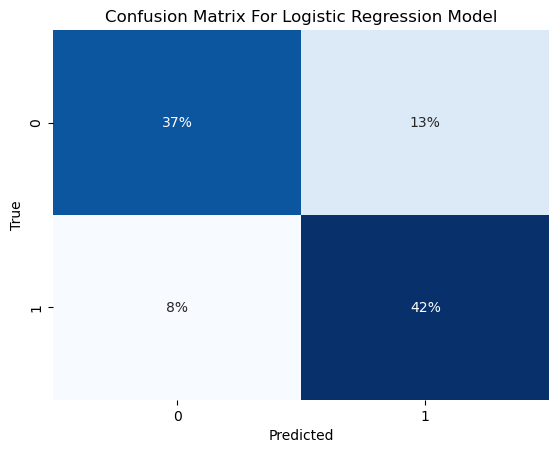

In [86]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalise
# cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Heatmap for confusion matrix
sns.heatmap(cm/np.sum(cm), annot=True, cmap="Blues", fmt=".0%", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix For Logistic Regression Model")
plt.show()

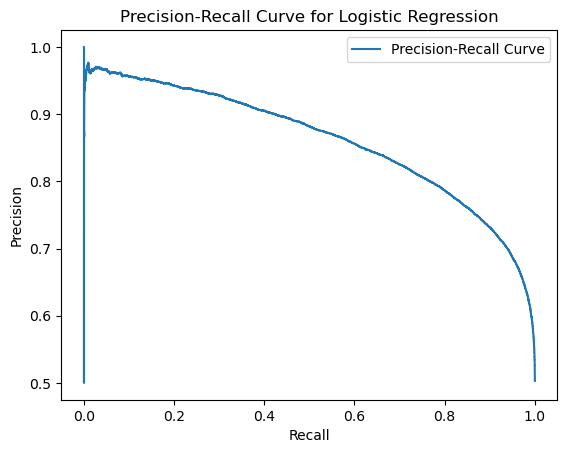

In [87]:
# Predicted probabilities
y_prob = lr_model.predict_proba(X_test)[:, 1]

# calculate precision and recall values at various thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

# plot precision-recall curve
import matplotlib.pyplot as plt

plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression')
plt.legend()
plt.show()

#### XGBoost

In [88]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [89]:
# convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# hyperparameters
params = {
    'max_depth': 3,
    'eta': 0.1,
    'objective': 'reg:squarederror'
}

# train the model
num_rounds = 100
xgb_model = xgb.train(params, dtrain, num_rounds)

# make prediction on test data
y_pred_xgboost = xgb_model.predict(dtest)

# round predictions to the nearest integer
y_pred = [int(round(pred)) for pred in y_pred]

In [90]:
xgboost_mse = mean_squared_error(y_test, y_pred_xgboost)
print('Mean Squared Error = {:.3f}'.format(xgboost_mse))

xgboost_mae = mean_absolute_error(y_test, y_pred_xgboost)
print('Mean Absolute Error = {:.3f}'.format(xgboost_mae))

xgboost_r2 = r2_score(y_test, y_pred_xgboost)
print('R Squared score = {:.3f}'.format(xgboost_r2))

xgboost_rmse = np.sqrt(xgboost_mse)
print('Root Mean Squared Error = {:.3f}'.format(xgboost_rmse))

Mean Squared Error = 0.197
Mean Absolute Error = 0.414
R Squared score = 0.213
Root Mean Squared Error = 0.444


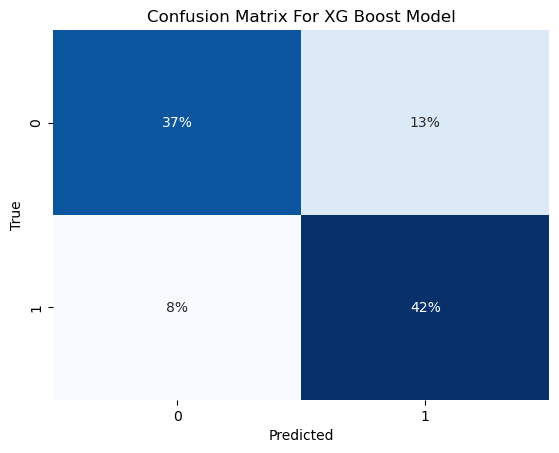

In [92]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalise
# cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Heatmap for confusion matrix
sns.heatmap(cm/np.sum(cm), annot=True, cmap="Blues", fmt=".0%", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix For XG Boost Model")
plt.show()

#### LSTM

In [ ]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.datasets import imdb
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, Activation
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences